# Fundamental Matrix and RANSAC

In this exercise, you will learn:
- how to estimate the fundamental matrix $F$ that geometrically relates two views of the same scene
- how to make your estimation more robust to outliers and noise which is important in practice

For some functions we already provide some draft implementation that you just need to complete. This is supposed to help you identifying the next steps. Still, if it does not fit your idea you may ignore it.

## 1. Setup

Load all libraries and both views that we will work with. In this exercise you are given two views again and matching key points which we extracted in advance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal

In [2]:
from matplotlib.patches import ConnectionPatch

# use this function to visualize the matches
def plot_matches(img1, img2, keypoints1, keypoints2):
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    
    # draw matches
    for kp1, kp2 in zip(keypoints1, keypoints2):
        c = np.random.rand(3)
        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color=c)
        fig.add_artist(con)
        axes[0].plot(*kp1, color=c, marker='x')
        axes[1].plot(*kp2, color=c, marker='x')
    
    plt.show()

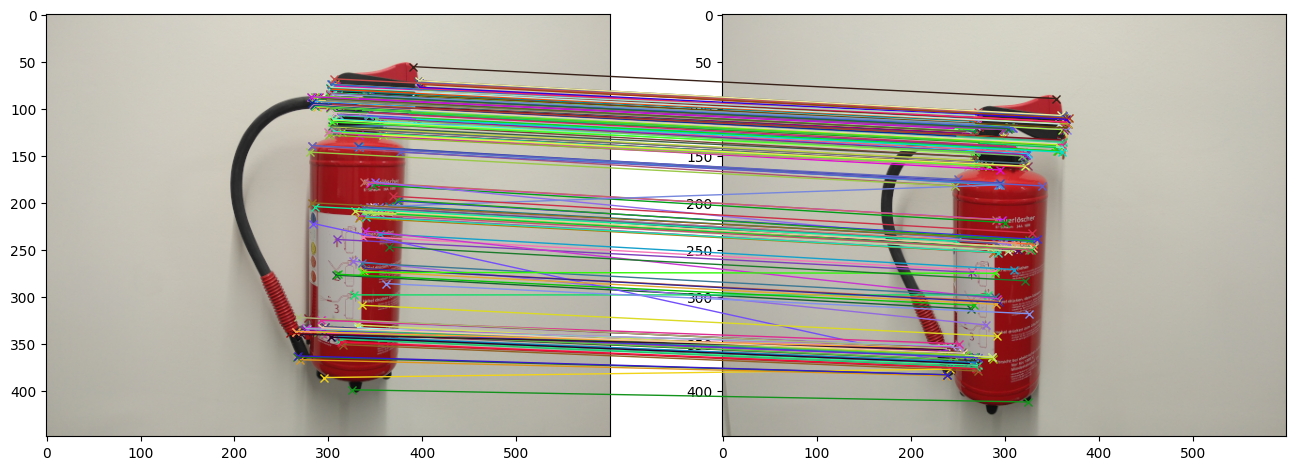

In [3]:
# Load images
view1 = np.array(Image.open("data/exercise3/view1.png")) / 255
view2 = np.array(Image.open("data/exercise3/view2.png")) / 255

# Load matching keypoints
with np.load("data/exercise4/keypoints.npz") as data:
    keypoints1 = data["view1"]
    keypoints2 = data["view2"]
    
plot_matches(view1, view2, keypoints1, keypoints2)

### 4.1. Fundamental Matrix
We begin with computing the fundamental matrix $F$ which defines the epipolar constraints for two views of two uncalibrated cameras. It determines the lines corresponding points can lie on. If we have a total of eight pairs of corresponding points this matrix can be estimated using the 8-point algorithm discussed in the lecture, see slide deck 

Your task now is to use eight point matches and compute the fundamental matrix $F$ by performing a direct linear transform and then decompose the resulting matrix using SVD. You might want to look at the slides again.

Hint: Use `numpy.linalg.svd` for singular value decomposition and do not forget to rescale the point coordinates to obtain stable results (this is termed 'conditioning' on the slides).

In [4]:
def find_fundamental_svd(kps1, kps2):
    """
    Estimate fundamental matrix using SVD 
    :param kps1: keypoints extracted from view1 in homogeneous coordinates
    :param kps2: keypoints extracted from view2 in homogeneous coordinates
    """
    assert len(kps1) == len(kps2)
    assert len(kps1) >= 8
    
    # condition points
    mean1 = np.mean(kps1, axis=0)
    mean2 = np.mean(kps2, axis=0)
    kps1  = kps1.astype(float) - mean1
    kps2  = kps2.astype(float) - mean2
    scale1 = np.sqrt(2) / np.std(kps1)
    scale2 = np.sqrt(2) / np.std(kps2)
    kps1 *= scale1
    kps2 *= scale2
    
    # collect equations
    A = np.zeros((len(kps1), 9))
    for i in range(len(kps1)):
        A[i] = [kps1[i, 0]*kps2[i, 0], kps1[i, 0]*kps2[i, 1], kps1[i, 0],
                kps1[i, 1]*kps2[i, 0], kps1[i, 1]*kps2[i, 1], kps1[i, 1],
                kps2[i, 0], kps2[i, 1], 1]
    
    # solve for fundamental matrix using SVD
    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # uncondition F
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    
    # make rank 2
    T1 = np.array([[scale1, 0, -scale1*mean1[0]], [0, scale1, -scale1*mean1[1]], [0, 0, 1]])
    T2 = np.array([[scale2, 0, -scale2*mean2[0]], [0, scale2, -scale2*mean2[1]], [0, 0, 1]])
    F = np.dot(T2.T, np.dot(F, T1))
        
    return F

In [5]:
# keypoints1_h = [np.append(kp, 1) for kp in keypoints1]
# keypoints2_h = [np.append(kp, 1) for kp in keypoints2]
F = find_fundamental_svd(keypoints1[:8], keypoints2[:8])

print("Fundamental Matrix:")
print(F)

Fundamental Matrix:
[[ 1.14134469e-05 -1.11582062e-04  2.39861762e-02]
 [ 1.22354151e-04  1.74259941e-05 -3.34607196e-02]
 [-3.63702537e-02  1.95143658e-02  4.03329925e+00]]


Check your code by visualizing the epipolar lines of you key points. We provide the function for this below. What do you see?

In [6]:
def visualize_epipolar_lines(img1, img2, keypoints1, keypoints2, F):
    """
    :params img1: view 1
    :params img2: view 2
    :params keypoints1: the key points from view 1 matching
                        with the key points from view 2
                        --> they are expected to be in homogenous coordinates
    :params keypoints2: the key points from view 2 matching
                        with the key points from view 1
                        --> they are expected to be in homogenous coordinates
    :params F: the fundamental matrix
    """
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    res = img1.shape[:2]
    
    for color_index, (kp1, kp2) in enumerate(zip(keypoints1, keypoints2)):
        c = np.random.rand(3)
        
        # plot points
        axes[0].plot(kp1[0], kp1[1], color=c, marker='o',markersize=5)
        axes[1].plot(kp2[0], kp2[1], color=c, marker='o',markersize=5)
        
        # compute epi lines
        epi_line_2 = kp1[None,...] @ F
        epi_line_1 = F @ kp2[None,...].T
        
        # plot lines
        for i, line in enumerate([epi_line_1, epi_line_2]):
            line = line.flatten()
            fn = lambda x: (line[0]*x + line[2]) / -line[1]
            xs = np.arange(res[1])
            axes[i].plot(xs, fn(xs), c=c)
    
    axes[0].set_ylim((res[0],0))
    axes[1].set_ylim((res[0],0))
    
    plt.show()

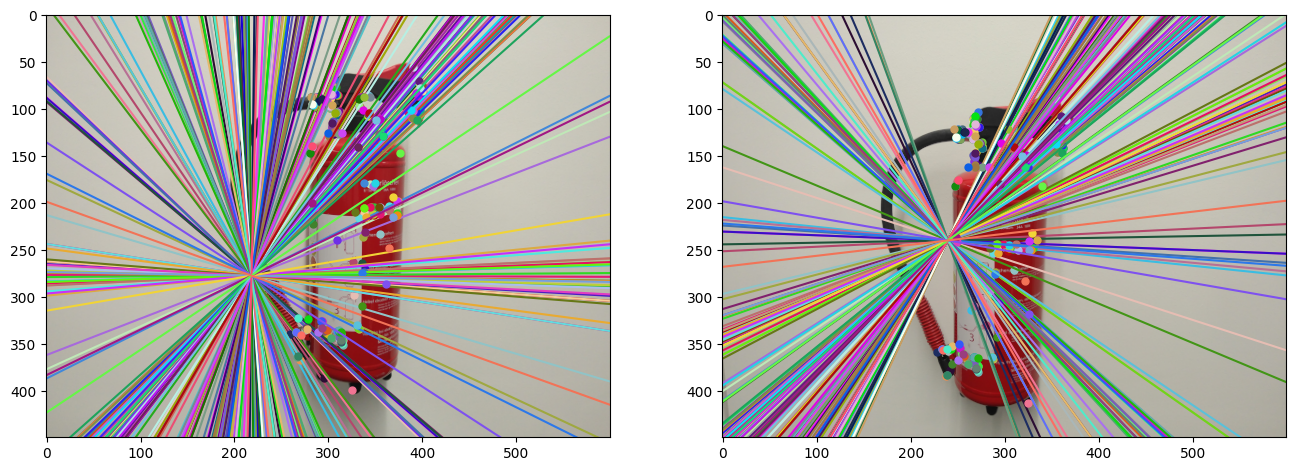

In [9]:
keypoints1 = np.concatenate((keypoints1, np.ones((keypoints1.shape[0],1))), axis=1)
keypoints2 = np.concatenate((keypoints2, np.ones((keypoints2.shape[0],1))), axis=1)
visualize_epipolar_lines(view1, view2, keypoints1, keypoints2, F)

Also, compute the algebraic error, i.e. how well is the epipolar contraint $x_0^TFx_1=0$ met.
Furthermore, calculate the geometric error, i.e. are the points far away from the epipolar lines.
What do the algebraic and geometric error values show you?

In [10]:
def algebraic_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        error = np.abs(kp1[None,...] @ F @ kp2[None,...].T)
        errors.append(error.item())
    return errors

def geometric_error(keypoints1, keypoints2, F):
    errors = []
    for kp1, kp2 in zip(keypoints1, keypoints2):
        x1F = kp1[None,...] @ F
        Fx2 = F @ kp2[None,...].T
        x1Fx2 = x1F @ kp2[None,...].T
        
        part1 = 1/(x1F.flatten()[0] ** 2 + x1F.flatten()[1] ** 2)
        part2 = 1/(Fx2.flatten()[0] ** 2 + Fx2.flatten()[1] ** 2)
        
        error = np.sqrt(x1Fx2 ** 2 * (part1 + part2))
        errors.append(error.item())
    return errors

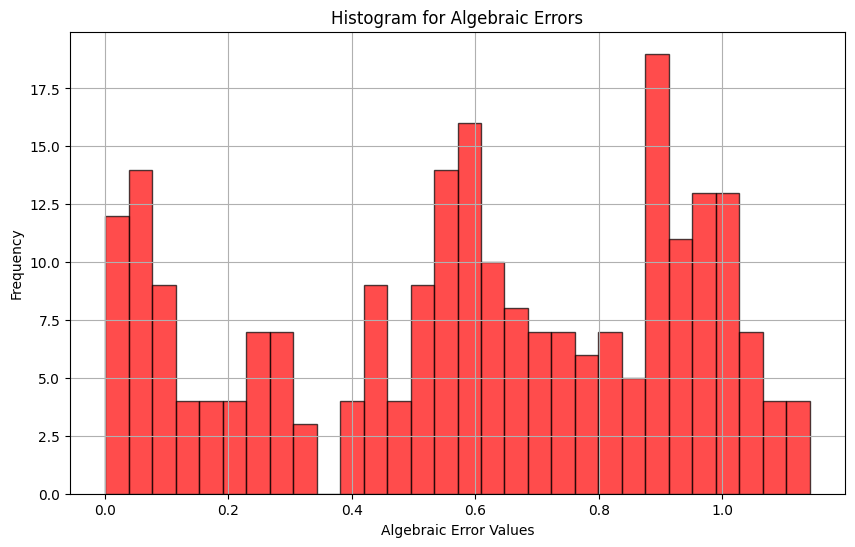

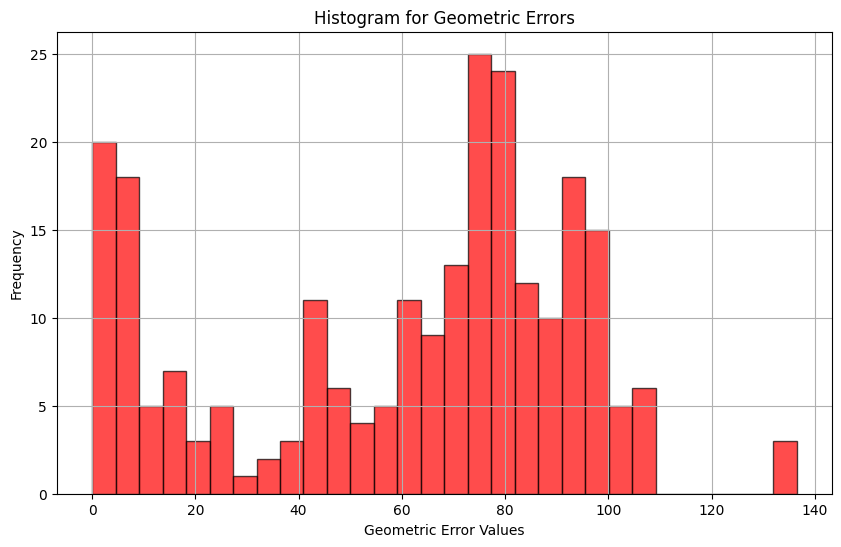

In [19]:
errors_algebraic = algebraic_error(keypoints1, keypoints2, F)
errors_geometric = geometric_error(keypoints1, keypoints2, F)

plt.figure(figsize=(10, 6))
plt.hist(errors_algebraic, bins=30, color='red', edgecolor='black', alpha=0.7)
plt.title('Histogram for Algebraic Errors')
plt.xlabel('Algebraic Error Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(errors_geometric, bins=30, color='red', edgecolor='black', alpha=0.7)
plt.title('Histogram for Geometric Errors')
plt.xlabel('Geometric Error Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### 4.2 Robust estimation using RANSAC
As some of the point matches suffer from noise or are even incorrect. The risk of obtaining an incorrect fundamental matrix by relying just on eight points is high. Hence, we are looking for a more robust version of estimating $F$. To do this, the RANSAC algorithm was introduced in the lecture. Your final task is to complete the implementation for fundamental matrix estimation by using RANSAC. You can compare the errors and epipolar lines of a robustly estimated $F$ with the one from the previous task.

In [20]:
def find_fundamental_ransac(keypoints1, keypoints2, num_samples=8, threshold=5, iterations=5000, min_inliers=30):
    """
    Optimizes fundamental matrix parameters using RANSAC algorithm
    :params keypoints1: the key points from view 1 matching
                        with the key points from view 2
                        --> they are expected to be in homogenous coordinates
    :params keypoints2: the key points from view 2 matching
                        with the key points from view 1
                        --> they are expected to be in homogenous coordinates
    :param num_samples: the number of samples to draw in each iteration
    :param threshold: determines the error value at which we decide for inlier or outlier
    :iterations: maximum number of iterations
    :returns: fundamental matrix and a binary mask indicating the inlier points in keypoints1 and keypoints2
    
    """
    best_F = None
    best_inlier_mask = None
    max_inliers = 0
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(keypoints1), num_samples, replace=False).astype(int)
        sampled_points1 = np.array(keypoints1)[sample_indices]
        sampled_points2 = np.array(keypoints2)[sample_indices]
        
        A = np.zeros((num_samples, 9))
        for i in range(num_samples):
            A[i] = [sampled_points1[i, 0]*sampled_points2[i, 0], sampled_points1[i, 0]*sampled_points2[i, 1], sampled_points1[i, 0],
                    sampled_points1[i, 1]*sampled_points2[i, 0], sampled_points1[i, 1]*sampled_points2[i, 1], sampled_points1[i, 1],
                    sampled_points2[i, 0], sampled_points2[i, 1], 1]
        _, _, V = np.linalg.svd(A)
        F = V[-1].reshape(3, 3)

        errors = np.abs(np.sum(sampled_points2 @ F @ sampled_points1.T, axis=1))

        inlier_mask = errors < threshold
        num_inliers = np.sum(inlier_mask)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_F = F
            best_inlier_mask = inlier_mask

            if num_inliers >= min_inliers:
                break

    return best_F, best_inlier_mask

        
    
        
    # return F, inlier_mask 

In [22]:
F, inliers = find_fundamental_ransac(keypoints1,keypoints2)

Now visualize again the epipolar lines and compute the errors. What has changed?

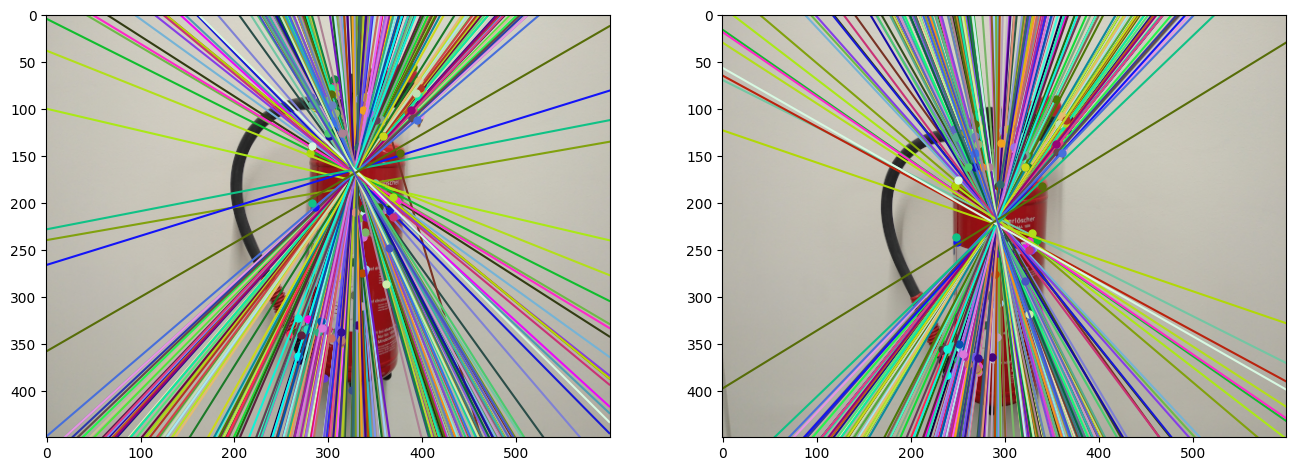

In [24]:
visualize_epipolar_lines(view1, view2, keypoints1, keypoints2, F)

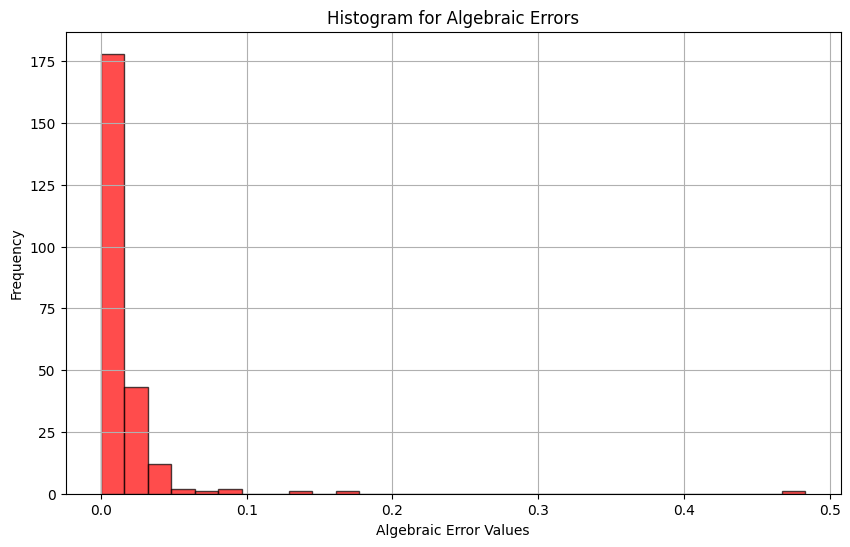

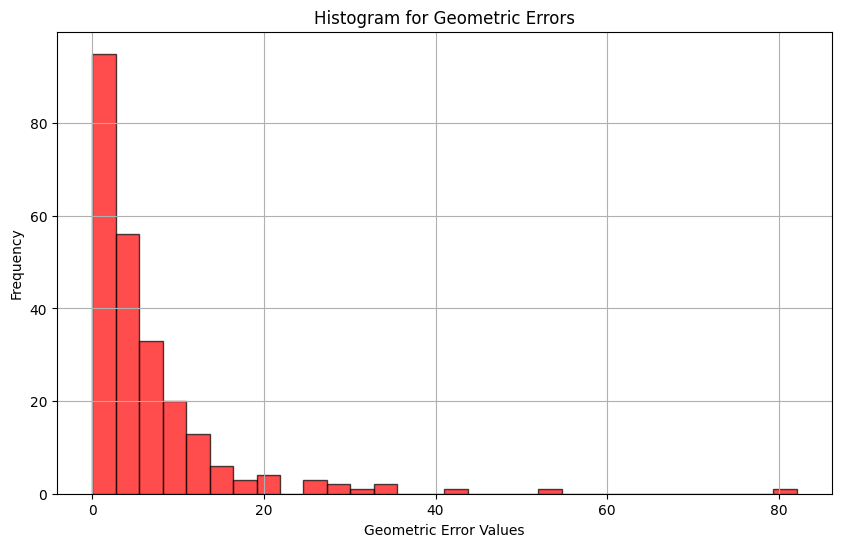

In [25]:
errors_algebraic = algebraic_error(keypoints1, keypoints2, F)
errors_geometric = geometric_error(keypoints1, keypoints2, F)

plt.figure(figsize=(10, 6))
plt.hist(errors_algebraic, bins=30, color='red', edgecolor='black', alpha=0.7)
plt.title('Histogram for Algebraic Errors')
plt.xlabel('Algebraic Error Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(errors_geometric, bins=30, color='red', edgecolor='black', alpha=0.7)
plt.title('Histogram for Geometric Errors')
plt.xlabel('Geometric Error Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()